In [1]:
using Markdown
using InteractiveUtils
using Graphs, Random, GraphPlot, Plots, Colors, GraphRecipes
using ITensors, ITensorMPS, LinearAlgebra

In [2]:

function adj_mat_lin(N::Int)
    A = zeros(N, N)
    for i in 1:N-1
        A[i, i+1] = 1.0
        A[i+1, i] = 1.0
    end
    return A
end

function adj_mat_ent(N::Int)
    A = ones(N, N)
    A -= Matrix{Float64}(I, N, N) # Set diagonal to zero (no self-coupling)
    return A
end

adj_mat_ent (generic function with 1 method)

In [3]:
function create_MPS(L::Int, Χ::Int; conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    init_state = [isodd(i) ? "Up" : "Dn" for i = 1:L] # antiferromagnetic ground state
    # THIS IS IMPORTANT - SEE NOTE BELOW
    # it sets the subspace of states we are allowed to explore
    # for example, this init_state means we only explore states with total Sz = 0 (i.e. zero magnetisation)
    # this is a reasonable assumption for positive J, but not for negative J
    # if we want to explore ferromagnetic states (negative J), we would need a different init_state
    ψ0 = randomMPS(sites, init_state)
    return ψ0, sites
end

create_MPS (generic function with 1 method)

In [4]:
function plot_adjacency_matrix(adj_mat; layout_type::String = "circular")
    """
    Plot the graph represented by the adjacency matrix.

    layout_type can be "circular", "spring", "spectral", or "random".
    """

    layout_lookup = Dict("circular" => circular_layout,
                         "spring" => spring_layout,
                         "spectral" => spectral_layout,
                         "random" => random_layout)

    G = Graphs.SimpleGraph(adj_mat)
    N = size(adj_mat, 1)

    node_labels = [string(i) for i in 1:N]

    p = GraphPlot.gplot(
        G, 
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.3,
        nodelabelsize=3,
        edgelinewidth=2.0,
    ) # plot the graph with the specified layout
    display(p)
    return p
end

plot_adjacency_matrix (generic function with 1 method)

In [5]:
function create_xxz_hamiltonian_exact(N::Int, adj_mat, J::Float64, Δ::Float64)
    """
    Constructs the exact Hamiltonian matrix for the XXZ model based on a given adjacency matrix.
    """
    dim = 2^N
    H = zeros(ComplexF64, dim, dim)

    # Define single-site S=1/2 operators and Identity
    Sp = [0.0 1.0; 0.0 0.0]
    Sm = [0.0 0.0; 1.0 0.0]
    Sz = 0.5 * [1.0 0.0; 0.0 -1.0]
    Id = Matrix{Float64}(I, 2, 2)

    # Helper function to build a full 2^N x 2^N operator using Kronecker products
    function build_op(op_map::Dict{Int, Matrix{Float64}})
        full_op = 1.0
        for i in 1:N
            op = get(op_map, i, Id)
            full_op = kron(full_op, op)
        end
        return full_op
    end

    # Construct the Hamiltonian by summing terms for each interacting pair from the adj_mat
    for i in 1:N-1
        for j in i+1:N
            if adj_mat[i, j] == 1.0
                # Term: J/2 * (Sᵢ⁺Sⱼ⁻ + Sᵢ⁻Sⱼ⁺)
                H .+= (J / 2) * build_op(Dict(i => Sp, j => Sm))
                H .+= (J / 2) * build_op(Dict(i => Sm, j => Sp))
                
                # Term: J*Δ*SᵢᶻSⱼᶻ
                H .+= (J * Δ) * build_op(Dict(i => Sz, j => Sz))
            end
        end
    end
    return H
end

create_xxz_hamiltonian_exact (generic function with 1 method)

In [6]:
function solve_xxz_hamiltonian_exact(H)
    eigens = eigen(Hermitian(H))
    eigenvalues = eigens.values
    ground_state = minimum(eigenvalues)
    ψ = eigens.vectors[:, argmin(eigenvalues)]
    return eigens, ground_state, ψ
end

solve_xxz_hamiltonian_exact (generic function with 1 method)

In [7]:
# from ASH - XXZ Hamiltonian as an MPO. Not sure why mine didn't work in comparison to this
function create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
    ampo = OpSum()
    for i = 1:N-1
        for j = i+1:N
            if adj_mat[i, j] == 1  # if there is some entanglement between i and j
                # XX and YY terms: S+S- + S-S+ = 2(SxSx + SySy)
                # So to get J(SxSx + SySy), we need J/2 * (S+S- + S-S+)
                ampo += J/2, "S+", i, "S-", j
                ampo += J/2, "S-", i, "S+", j
                # ZZ term
                ampo += J*Δ, "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end

create_xxz_hamiltonian_mpo (generic function with 1 method)

In [8]:
function solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps::Int=10, bond_dim::Int=1000, cutoff::Float64=1E-14)
    """Solves the XXZ Hamiltonian using DMRG with given parameters. Returns the ground state energy and MPS. """
    swps = Sweeps(sweeps)
    setmaxdim!(swps, bond_dim)
    setcutoff!(swps, cutoff)
    E, ψ = dmrg(H, ψ0, swps; outputlevel=0)
    return E, ψ # only ground state and ground state wavefunction
end

solve_xxz_hamiltonian_dmrg (generic function with 4 methods)

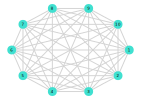

Ground state energy from DMRG: -4.374999999999997
Time taken for DMRG: 61.8855289 seconds
Ground state energy from ED:   -4.375000000000005
Time taken for ED: 1.437909 seconds
Difference between DMRG and ED energies: 7.993605777301127e-15
Relative difference: -1.827109891954541e-15
Fidelity (Overlap |<ψ_ED|ψ_DMRG>|²): 0.044990893976148465
Error bound from fidelity (1 - F): 0.9550091060238516


In [9]:
# parameters
N = 10 # number of nodes
Χ = 100 # bond dimension
J = 1.0 # coupling constant
Δ = 1.5 # anisotropy parameter
sweeps = 10 # number of DMRG sweeps

adj_mat = adj_mat_ent(N)
plot_adjacency_matrix(adj_mat; layout_type="circular")

# DMRG
ψ0, sites = create_MPS(N, Χ; conserve_qns = false)
H_mpo = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
dmrg_time = @elapsed E_dmrg, ψ_dmrg = solve_xxz_hamiltonian_dmrg(H_mpo, ψ0, sweeps, Χ)
println("Ground state energy from DMRG: $E_dmrg")
println("Time taken for DMRG: $dmrg_time seconds")

# ED
H_exact = create_xxz_hamiltonian_exact(N, adj_mat, J, Δ)
exact_time = @elapsed eigens_exact, E_exact, ψ_exact = solve_xxz_hamiltonian_exact(H_exact)
println("Ground state energy from ED:   $E_exact")
println("Time taken for ED: $exact_time seconds")

println("Difference between DMRG and ED energies: $(E_dmrg - E_exact)")
println("Relative difference: $((E_dmrg - E_exact) / E_exact)")



# ordering of the dmrg mps into a vector
itensor_gs = ITensors.contract(ψ_dmrg)
array_gs = array(itensor_gs)
ψ_dmrg_vec = vec(array_gs)

# Calculate the squared overlap (fidelity) between the WAVEFUNCTION VECTORS
fidelity = abs(dot(ψ_exact, ψ_dmrg_vec))^2

println("Fidelity (Overlap |<ψ_ED|ψ_DMRG>|²): $fidelity")
println("Error bound from fidelity (1 - F): $(1 - fidelity)")

N = 2, Error = 6.661338147750939e-16
N = 3, Error = 0.0
N = 4, Error = 1.7763568394002505e-15
N = 5, Error = 1.5543122344752192e-15
N = 6, Error = 4.440892098500626e-16
N = 7, Error = 2.220446049250313e-15
N = 8, Error = 2.6645352591003757e-15
N = 9, Error = 6.661338147750939e-15
N = 10, Error = 7.993605777301127e-15


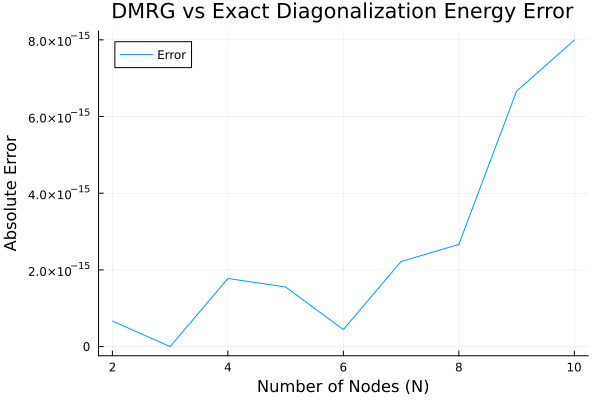

In [10]:
function run_and_plot_error_analysis(N_max::Int, Χ::Int, J::Float64, Δ::Float64, sweeps::Int)

    N_values = Int[]
    errors = Float64[]


    for N in 2:N_max
        try
            adj_mat = adj_mat_ent(N)

            ψ0, sites = create_MPS(N, Χ; conserve_qns=false)
            H_mpo = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
            E_dmrg, _ = solve_xxz_hamiltonian_dmrg(H_mpo, ψ0, sweeps, Χ)

            H_exact = create_xxz_hamiltonian_exact(N, adj_mat, J, Δ)
            _, E_exact, _ = solve_xxz_hamiltonian_exact(H_exact)

            error = abs(E_dmrg - E_exact)
            push!(N_values, N)
            push!(errors, error)

            println("N = $N, Error = $error")

        catch e
            println("An error occurred at N = $N: $e")
            println("Stopping analysis. This may be due to memory limits for ED.")
            break # Exit the loop if an error occurs (e.g., OutOfMemoryError)
        end
    end

    return N_values, errors
end

N = 10        # Number of nodes
Χ = 100      # Bond dimension
J = 1.0      # Coupling constant
Δ = 1.5      # Anisotropy parameter
sweeps = 10  # Number of DMRG sweeps

N_values, errors = run_and_plot_error_analysis(N, Χ, J, Δ, sweeps);

display(plot(N_values, errors,
    title="DMRG vs Exact Diagonalization Energy Error",
    xlabel="Number of Nodes (N)",
    ylabel="Absolute Error",
    label="Error",
    # marker=:circle,
    # yaxis=:log10,
    # legend=:topleft,
    # xticks=1:N
))

N = 2, Fidelity = 1.0, Infidelity = 0.0
N = 3, Fidelity = 1.0, Infidelity = 0.0
N = 4, Fidelity = 0.9999999999999998, Infidelity = 2.220446049250313e-16
N = 5, Fidelity = 0.0748436145046909, Infidelity = 0.9251563854953091
N = 6, Fidelity = 0.06576786054579974, Infidelity = 0.9342321394542002
N = 7, Fidelity = 0.000468811343499288, Infidelity = 0.9995311886565007
N = 8, Fidelity = 0.012001586847198703, Infidelity = 0.9879984131528013
N = 9, Fidelity = 0.0034230438012646572, Infidelity = 0.9965769561987353
N = 10, Fidelity = 0.044990893976148465, Infidelity = 0.9550091060238516


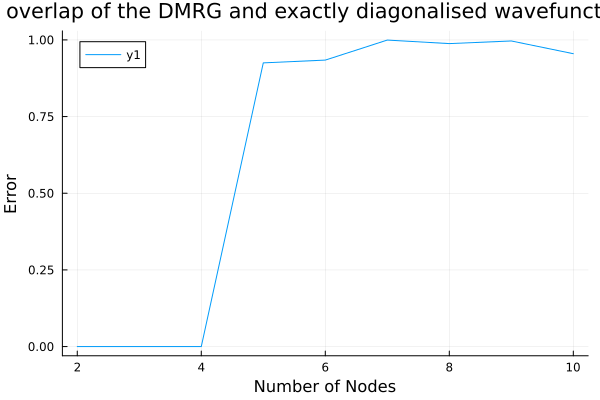

In [14]:
function run_and_plot_infidelity_analysis(N_max::Int, Χ::Int, J::Float64, Δ::Float64, sweeps::Int)
    """
    Runs DMRG and ED for N = 2 to N_max, calculates the wavefunction infidelity 
    (1 - Fidelity), and plots the results.
    """
    N_values = Int[]
    errors = Float64[]


    # Start loop from N=2
    for N in 2:N_max
        try
            adj_mat = adj_mat_ent(N)

            # DMRG 
            ψ0, sites = create_MPS(N, Χ; conserve_qns=false)
            H_mpo = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
            _, ψ_dmrg = solve_xxz_hamiltonian_dmrg(H_mpo, ψ0, sweeps, Χ)

            # ED 
            H_exact = create_xxz_hamiltonian_exact(N, adj_mat, J, Δ)
            _, _, ψ_exact = solve_xxz_hamiltonian_exact(H_exact)

            # Convert MPS to a standard vector to compare with ED vector
            itensor_gs = ITensors.contract(ψ_dmrg)
            ψ_dmrg_vec = vec(array(itensor_gs, sites...))
            
            fidelity = abs(dot(ψ_exact, ψ_dmrg_vec))^2
            
            # The "Error" for the graph is the infidelity
            error = 1.0 - fidelity
            
            push!(N_values, N)
            push!(errors, error)

            println("N = $N, Fidelity = $fidelity, Infidelity = $error")
        catch e
            println("An error occurred at N = $N: $e")
            println("Stopping analysis. This may be due to memory limits for ED.")
            break
        
        end
    end




    return N_values, errors
end

N = 10       # Number of nodes
Χ = 100      # Bond dimension
J = 1.0      # Coupling constant
Δ = 1.5      # Anisotropy parameter
sweeps = 10  # Number of DMRG sweeps

N_values, infidelity = run_and_plot_infidelity_analysis(N, Χ, J, Δ, sweeps);


display(plot(N_values, infidelity,
    title="overlap of the DMRG and exactly diagonalised wavefunctions",
    xlabel="Number of Nodes",
    ylabel="Error",
    # label=nothing, # No legend label in the target graph
    # marker=:circle,
    # markersize=5,
    # markerstrokecolor=:auto,
    # linewidth=2
))